# Training Deep Neural Networks

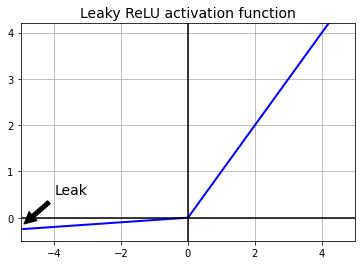

In [5]:
#complex problems such as detecting hundreds of object types may require DNN to be trained.
#issues we could encounter:
    #-vanishing gradients/exploding gradients, 
    #-not enough training data
    #-extemely slow training
    #-severe risk of overfitting

#Start with addressing the gradients issue.

#vanishing gradients is when the gradient descent update leaves the lower layers connection weights unchanged
#never converges to a solution
#opposite is exploding gradients, where layers get extremely large weight updates.
#generally, NNs experience unstable gradients with diff layers learning at diff speeds.

#A key way around this issue is down to the initialization of the network.
#Using Glorot/LeCun initialization. Keras uses Glorot initialization by default.

#Can change to He initialization like so:

    #keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

#He initialization with uniform distibution, but based on FANavg instead of FANin

    #he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
    #keras.layers.Dense(10, activation='relu', kernel_initializer='he_avg_init')

#Choice of activation functions v important. ReLU does not saturate positive values and is fast to compute.
#Some downsides include dying ReLUs where some neurons stop outputting anything but 0
#This can be solved with 'leaky ReLU'. LeakyRELU(z) = max(az,z). This generally performs better, for a given leak a

import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5, 5, 200)

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

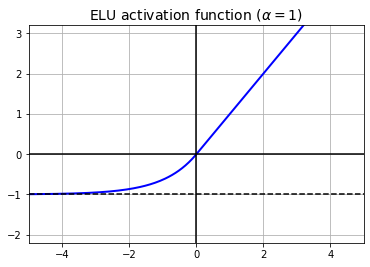

In [6]:
#Another alternative is ELU, Exponential LU.
#main drawback of this is that it is slower to compute than ReLU

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [7]:
#Scaled ELU often significantly outperforms other activation functions. There are conditions for its use:
#input features must be standardized
#hidden layers weights must be initialized with LeCun
#network architecture must be sequential.

#With these conditions, SELU will self-normalize

#To use leaky relu, create a leaky relu layer after the layer you apply it to.

    #keras.layers.Dense(10, kernel_initializer='he_normal')
    #keras.layers.LeakyReLU(alpha=0.2)
    
#for selu:

    #keras.layers.Dense(10, activation='selu', kernel_initializer='lecun_normal')

In [9]:
#using He initialization with ELU doesn't guarantee that gradients issues won't reappear during training
#Can use Batch normalization to alleviate this.

#add an operation in the model just before or after activation function which zero centers and normalizes each input
#then scales and shifts the result

#in summary, standardizes inputs, rescales, then offsets.
#improves performance greatly on image classifiers for ex.
#implementation looks like:

import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [11]:
#check params of first BN layer

[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [12]:
#can add the BN layers before in sequence as well:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
#another technique to mitigate exploding gradients is to clip them during backpropagation

optimizer = keras.optimizers.SGD(clipvalue=1.0)

#model.compile(loss='mse', optimizer=optimizer)

#this optimizaer clips every component of the gradient vector to a value between 1 and -1

In [14]:
#generally, we don't want to build a DNN from scratch, try to find existing NN
#This is transfer learning. Eg.

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [15]:
X_train_A.shape

(43986, 28, 28)

In [16]:
X_train_B.shape

(200, 28, 28)

In [17]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [18]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [19]:
#create a model A

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [20]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [21]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 10s 6ms/step - loss: 0.6136 - accuracy: 0.7945 - val_loss: 0.4080 - val_accuracy: 0.8595
Epoch 2/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3743 - accuracy: 0.8695 - val_loss: 0.3362 - val_accuracy: 0.8884
Epoch 3/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.3286 - accuracy: 0.8851 - val_loss: 0.3127 - val_accuracy: 0.8931
Epoch 4/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3038 - accuracy: 0.8936 - val_loss: 0.2925 - val_accuracy: 0.8991
Epoch 5/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2884 - accuracy: 0.8998 - val_loss: 0.2855 - val_accuracy: 0.9021
Epoch 6/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2772 - accuracy: 0.9034 - val_loss: 0.2757 - val_accuracy: 0.9041
Epoch 7/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2679 - accuracy: 0.9087 - val_loss: 0.2690 - val_accuracy

In [22]:
#save this model, we will use it to build on next

model_A.save("my_model_A.h5")

In [23]:
#Now create your model B for binary classification

model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [24]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [25]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 2s 95ms/step - loss: 0.7230 - accuracy: 0.5950 - val_loss: 0.6107 - val_accuracy: 0.6389
Epoch 2/20
7/7 [==============================] - 0s 33ms/step - loss: 0.5073 - accuracy: 0.7150 - val_loss: 0.4400 - val_accuracy: 0.7992
Epoch 3/20
7/7 [==============================] - 0s 34ms/step - loss: 0.3715 - accuracy: 0.8800 - val_loss: 0.3563 - val_accuracy: 0.8580
Epoch 4/20
7/7 [==============================] - 0s 33ms/step - loss: 0.3015 - accuracy: 0.9050 - val_loss: 0.3022 - val_accuracy: 0.8966
Epoch 5/20
7/7 [==============================] - 0s 34ms/step - loss: 0.2548 - accuracy: 0.9450 - val_loss: 0.2590 - val_accuracy: 0.9249
Epoch 6/20
7/7 [==============================] - 0s 34ms/step - loss: 0.2180 - accuracy: 0.9550 - val_loss: 0.2284 - val_accuracy: 0.9452
Epoch 7/20
7/7 [==============================] - 0s 34ms/step - loss: 0.1910 - accuracy: 0.9650 - val_loss: 0.2057 - val_accuracy: 0.9513
Epoch 8/20
7/7 [===========

In [26]:
#check the details of our model B

model_B.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 300)               235500    
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 1)                

In [27]:
#Now comes the transfer learning step.
#load all layers from model A into model B on A except for the last one
#add another final layer for binary classification

model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [29]:
#create a clone of model A

model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [30]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [31]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 2s 93ms/step - loss: 0.9756 - accuracy: 0.4800 - val_loss: 0.9653 - val_accuracy: 0.5294
Epoch 2/4
7/7 [==============================] - 0s 32ms/step - loss: 0.8995 - accuracy: 0.5150 - val_loss: 0.8986 - val_accuracy: 0.5588
Epoch 3/4
7/7 [==============================] - 0s 31ms/step - loss: 0.8333 - accuracy: 0.5600 - val_loss: 0.8370 - val_accuracy: 0.5923
Epoch 4/4
7/7 [==============================] - 0s 32ms/step - loss: 0.7729 - accuracy: 0.5950 - val_loss: 0.7818 - val_accuracy: 0.6298
Epoch 1/16
7/7 [==============================] - 2s 93ms/step - loss: 0.5911 - accuracy: 0.7100 - val_loss: 0.4469 - val_accuracy: 0.8154
Epoch 2/16
7/7 [==============================] - 0s 34ms/step - loss: 0.3590 - accuracy: 0.8650 - val_loss: 0.3016 - val_accuracy: 0.9168
Epoch 3/16
7/7 [==============================] - 0s 31ms/step - loss: 0.2493 - accuracy: 0.9300 - val_loss: 0.2344 - val_accuracy: 0.9473
Epoch 4/16
7/7 [===============

In [32]:
#now compare our results

model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.0999 - accuracy: 0.9785


[0.09989636391401291, 0.9785000085830688]

In [33]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 4ms/step - loss: 0.0729 - accuracy: 0.9900


[0.07287653535604477, 0.9900000095367432]

In [34]:
#shows a great improvement through transfer learning.
#transfer learning works best with deep CNNs.

#Learning rate scheduling is another important technique
#finding an optimal learning rate at each point of training helps to achieve a better solution.

#implementing power scheduling in keras

#optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

#more detail in the text.


In [36]:
#avoiding overfitting through regularization

#early stopping is one of the best regularization techniques.
#other popular methods are l1, l2, dropout and maxnorm

#l1 and l2 first

layer = keras.layers.Dense(100, activation='elu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(0.01))

In [37]:
#you will want to apply same regularizer to each layer
#can use partial to create a wrapper.

from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                          activation='elu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax',
                    kernel_initializer='glorot_uniform')
])

In [38]:
#dropout is a popular regularizer. randomly drops neurons during training steps.

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation='softmax')
])

In [40]:
#Monte Carlo Dropout is an important technique which can boost models performance significantly. 
#Simple to implement

#Final technique is max norm regularization

keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal',
                  kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
#if a network is a stack of dense layers, it should be able to self normalize.


